In [2]:
import pandas as pd
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import random
from tensorflow.keras.models import load_model
import os
import shutil
from PIL import Image


In [3]:


path_train = '/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/Train'
path_train_modi = '/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/Train_modi'
path_test = '/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/test'

def imagen_90(image_path):
    imagen = Image.open(image_path)
    imagen_rgb = imagen.convert('RGB')
    return imagen_rgb.rotate(90)

def imagen_hor(image_path):
    imagen = Image.open(image_path)
    imagen_rgb = imagen.convert('RGB')
    return imagen_rgb.transpose(Image.FLIP_LEFT_RIGHT)

def imagen_ver(image_path):
    imagen = Image.open(image_path)
    imagen_rgb = imagen.convert('RGB')
    return imagen_rgb.transpose(Image.FLIP_TOP_BOTTOM)

def cambio_carpetas(path, path_destino):
    imagenes = []
    count = 0

    for directorio, _, archivos in os.walk(path):
        for archivo in archivos:
            if archivo.lower().endswith(('.jpg', '.png', '.jpeg')):
                archivo_path = os.path.join(directorio, archivo)
                imagenes.append(archivo_path)
    
    for img_path in imagenes:
        rel_path = os.path.relpath(img_path, path)
        parts = rel_path.split(os.sep)
        
        if len(parts) > 1 and parts[0] == 'Packages':
            continue
            
        if len(parts) > 1:
            class_folder = parts[0]
        else:
            class_folder = 'unknown'

        dest_dir = os.path.join(path_destino, class_folder)
        os.makedirs(dest_dir, exist_ok=True)
        
        filename = os.path.basename(img_path)
        name, ext = os.path.splitext(filename)
        
        try:
            shutil.copy(img_path, os.path.join(dest_dir, filename))
            imagen_90(img_path).save(os.path.join(dest_dir, f"{name}_90{ext}"))
            imagen_hor(img_path).save(os.path.join(dest_dir, f"{name}_hor{ext}"))
            imagen_ver(img_path).save(os.path.join(dest_dir, f"{name}_ver{ext}"))
            
            count += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    print(f"Successfully processed {count} images")
if __name__ == "__main__":
    cambio_carpetas(path_train, path_train_modi)

Successfully processed 209 images


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

In [5]:
img_height = 348
img_width = 348
batch_size = 3

In [6]:
train_generator = train_datagen.flow_from_directory(
    path_train_modi,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') 

Found 836 images belonging to 3 classes.


In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
val_generator = val_datagen.flow_from_directory(
    path_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') 

Found 50 images belonging to 3 classes.


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

C:\Users\jacar\AppData\Local\Temp\ipykernel_23184\2631993559.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


In [10]:
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True


In [14]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax') 
])


In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [16]:

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 107s 350ms/step - accuracy: 0.4888 - loss: 1.0629 - val_accuracy: 0.4200 - val_loss: 2.4977
Epoch 2/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 98s 350ms/step - accuracy: 0.6412 - loss: 0.7982 - val_accuracy: 0.4800 - val_loss: 1.6851
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 97s 348ms/step - accuracy: 0.7618 - loss: 0.5794 - val_accuracy: 0.5800 - val_loss: 1.2154
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 98s 352ms/step - accuracy: 0.7639 - loss: 0.5766 - val_accuracy: 0.7400 - val_loss: 0.8470
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 98s 349ms/step - accuracy: 0.7834 - loss: 0.5261 - val_accuracy: 0.7000 - val_loss: 1.0573
Epoch 6/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 103s 369ms/step - accuracy: 0.8076 - loss: 0.4634 - val_accuracy: 0.7600 - val_loss: 0.8611
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 103s 370ms/step - accuracy: 0.8075 - loss: 0.4826 - val_accuracy: 0.7800 - val_loss: 0.9954
Epoch 8/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 102s 367ms/step - accuracy: 0.8867 - los

In [19]:
model.save('/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/Model_final.h5')

In [20]:
model = load_model("/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/Model_final.h5")

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 11, 11, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,397 (11.12 MB)

 Trainable params: 2,518,851 (9.61 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2 (12.00 B)

In [21]:
score = model.evaluate(val_generator, verbose=1)
print(f'Pérdida: {score[0]}, Precisión: {score[1]}')


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.7029 - loss: 1.6425
Pérdida: 1.4810900688171387, Precisión: 0.6800000071525574


In [22]:
X_test = []
y_test = []

for i in range(len(val_generator)):
    batch_x, batch_y = next(val_generator)
    X_test.append(batch_x)
    y_test.append(batch_y)


X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print("Forma de X_test:", X_test.shape) 
print("Forma de y_test:", y_test.shape)  


Forma de X_test: (50, 348, 348, 3)
Forma de y_test: (50, 3)


In [23]:
y_test = np.argmax(y_test, axis=1)

In [24]:
y_test

array([2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2,
       1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2,
       0, 1, 1, 1, 0, 2], dtype=int64)

In [25]:
y_pred = model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [26]:
y_pred = np.argmax(y_pred, axis=1)


In [27]:
y_pred

array([0, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2,
       2, 1, 1, 1, 1, 2], dtype=int64)

In [28]:
print("Precision:")
print("- Test:", precision_score(y_test, y_pred, average='weighted'))
print("\nRecall:")
print("- Test:", recall_score(y_test, y_pred, average='weighted'))
print("\nF1:")
print("- Test:", f1_score(y_test, y_pred, average='weighted'))

Precision:
- Test: 0.7185347985347985

Recall:
- Test: 0.68

F1:
- Test: 0.6643809523809523


In [29]:
class_names = val_generator.class_indices
print(class_names)

{'Acero_expuesto': 0, 'Grietas_Fisuras': 1, 'Hormiguero': 2}


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=list(class_names)))

                 precision    recall  f1-score   support

 Acero_expuesto       0.29      0.25      0.27         8
Grietas_Fisuras       0.67      1.00      0.80        20
     Hormiguero       0.92      0.55      0.69        22

       accuracy                           0.68        50
      macro avg       0.63      0.60      0.58        50
   weighted avg       0.72      0.68      0.66        50



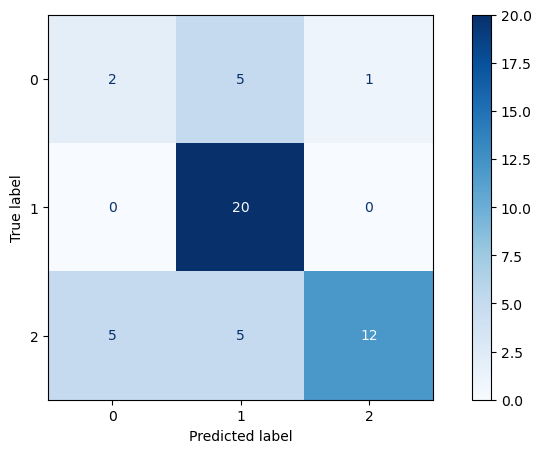

In [36]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix


cfn_matrix  = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cfn_matrix)
fig, ax = plt.subplots(figsize=(10, 5))
cm_display.plot(ax=ax, cmap='Blues')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

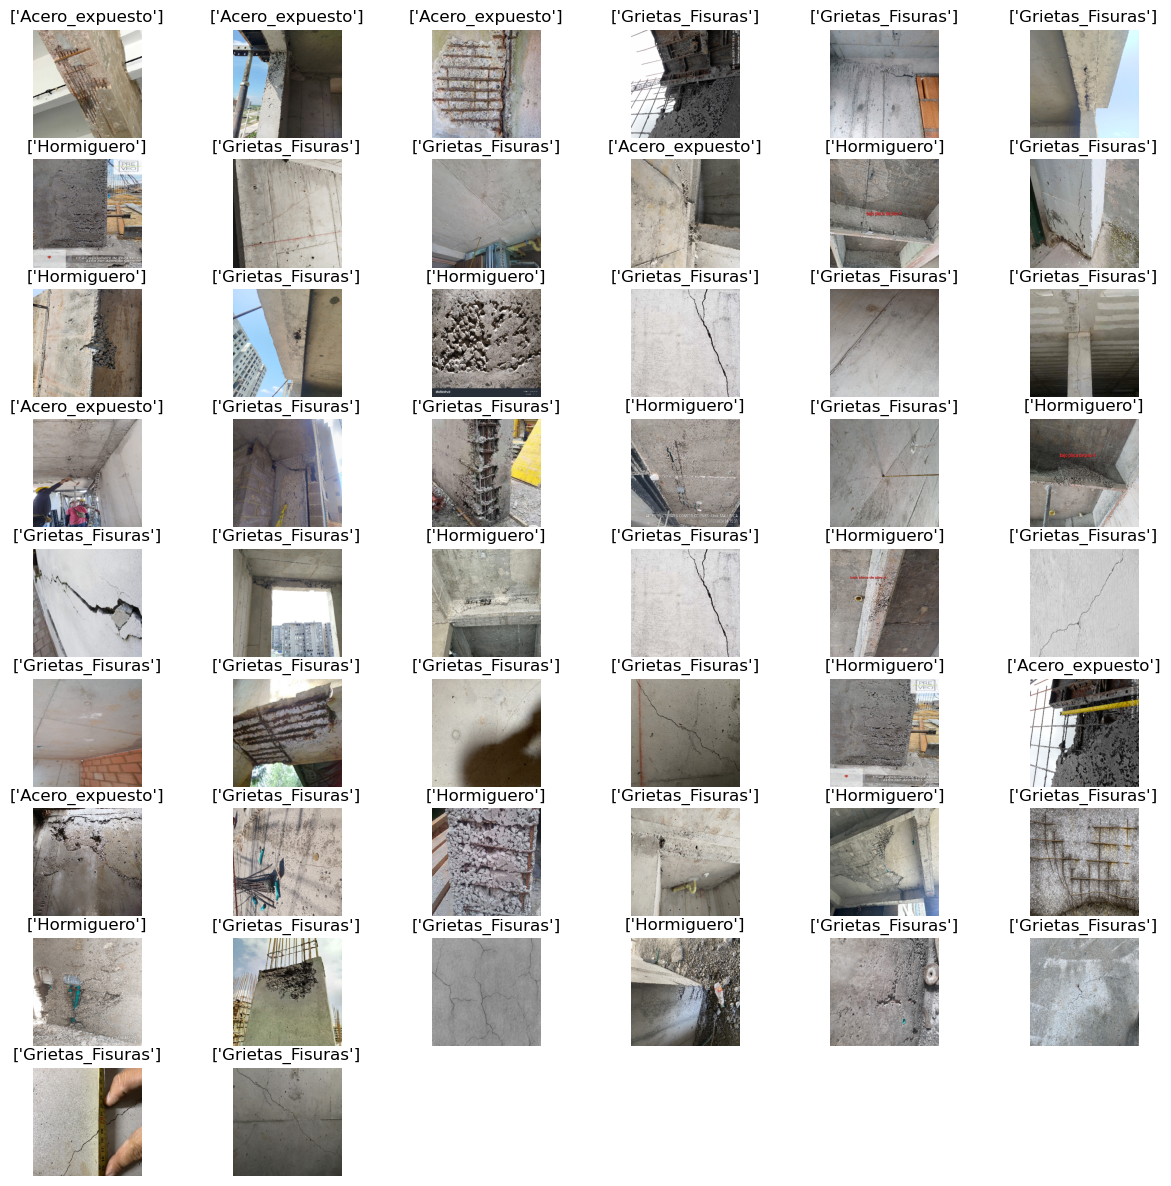

In [37]:
path_validacion = '/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/test' 
imagenes=[]
for directorio, _, archivos in os.walk(path_validacion):
        for archivo in archivos:
            if archivo.lower().endswith(('.jpg', '.png', '.jpeg')):
                archivo_path = os.path.join(directorio, archivo)
                imagenes.append(archivo_path)


imagenes = random.sample(imagenes, 50)

cont=0
plt.figure(figsize=(15, 25))
for i in imagenes : 
    img_path = i
    img = image.load_img(img_path, target_size=(348, 348))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    prediccion = model.predict(img_array)
    clase_predicha = np.argmax(prediccion, axis=1)

    clave = [clave for clave, valor in class_names.items() if valor == clase_predicha]
    ax = plt.subplot(15, 6,cont+1)
    plt.imshow(np.squeeze(img_array))
    plt.title(clave)
    plt.axis("off")
    cont+= 1


plt.show()